# Predicting House Prices in Ames Iowa, A Data Science Project
### Gurpal Singh
### October 2019

## Introduction

This notebook explores the Ames housing data set which was collected in Ames Iowa. The training set contain 1460 instances and 81 features from an initial glance. This notebook will walk through the exploratory data analysis, cleaning the data, feature engineering, and model implementation. 

### The Problem at Hand

To fully grasp the problem we need to view it in the shoes of the client. In this case it would be anyone evaluating the price of home in Ames, Iowa. This could either be home buyer as well as a seller. When we look at features, we will need to determine which features are relevant to this outcome. The goal is to predict the saleprice of a home given the features in the Ames Dataset. 

## Loading Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings # ?
import missingno as msno
#import xgboost as xgb
#import lightgbm as lgb
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter
from sklearn.linear_model import LinearRegression, LassoCV, Ridge, LassoLarsCV, ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
warnings.filterwarnings('ignore')
%matplotlib inline

## Loading Data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Checking the number of instances and features 
shapetrain = train.shape
print('The size of training data is: ', shapetrain)
shapetest = test.shape
print('The size of testing data is: ', shapetest)

The size of training data is:  (1460, 81)
The size of testing data is:  (1459, 80)


In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Checking for Duplicated Data

In [4]:
# Function to check for Duplicate values in a column of dataframe
def check_duplicates(column):
    count = 0
    dups = 0
    for entry in column.duplicated():
        if entry is True:
            print('Duplicate Detected at index: ', count)
            dups += 1
        count +=1
    print('Duplicates detected: ',dups)

# Checking for duplicates
check_duplicates(train['Id'])
check_duplicates(test['Id'])

Duplicates detected:  0
Duplicates detected:  0


Since the Id column is not needed for prediction, we will drop it.

In [5]:
# Saving Id
train_ID = train['Id']
test_ID = test['Id']

# Dropping the 'Id' Column
train.drop('Id', axis = 1, inplace = True)
test.drop('Id', axis = 1, inplace = True)

# Checking Data Frame size after drop
# Checking the number of instances and features 
shapetrain = train.shape
print('The size of training data after dropping the ID column: ', shapetrain)
shapetest = test.shape
print('The size of testing data after dropping the ID column: ', shapetest)

The size of training data after dropping the ID column:  (1460, 80)
The size of testing data after dropping the ID column:  (1459, 79)


In [6]:
# Taking a look at the training data
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


 ## Target Variable Analysis
 In this case, the target variable is 'SalePrice'. 

In [7]:
# Description of the data
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

## Exploratory Data Analysis

In [8]:
# Describe method will give various statistics that exclude NaN Values
train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


Examining numerical feature  in the data set. We do this by looking at the object type within the dataframe. 

In [9]:
num_features = train.select_dtypes(include=[np.number])
print(num_features.columns)
print(num_features.shape)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
(1460, 37)


Examining categorical features in the training dataset


In [10]:
cat_features = train.select_dtypes(include=[np.object])
print(cat_features.columns)
print(cat_features.shape)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
(1460, 43)


The .info() method will give information about non-null entries in each column.

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

### Visualizations

Visualizing missing values for a sample of 250.

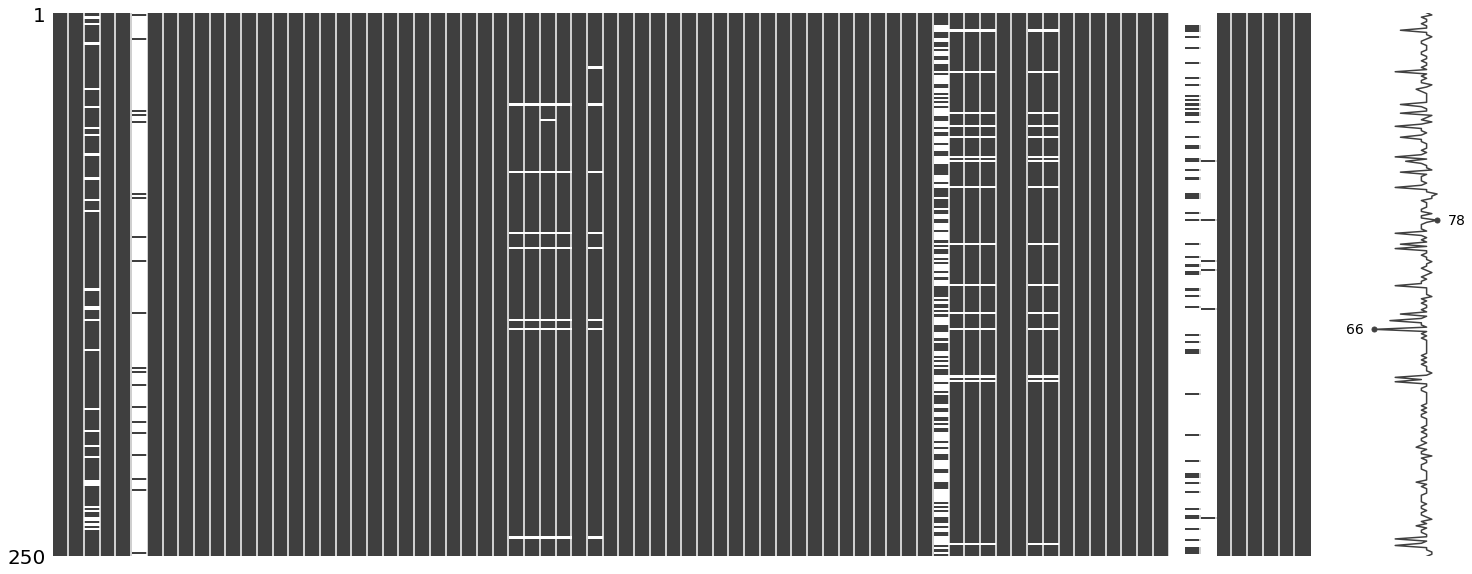

In [12]:
# If x labels are desired, also pass arguement labels=True
msno.matrix(train.sample(250))

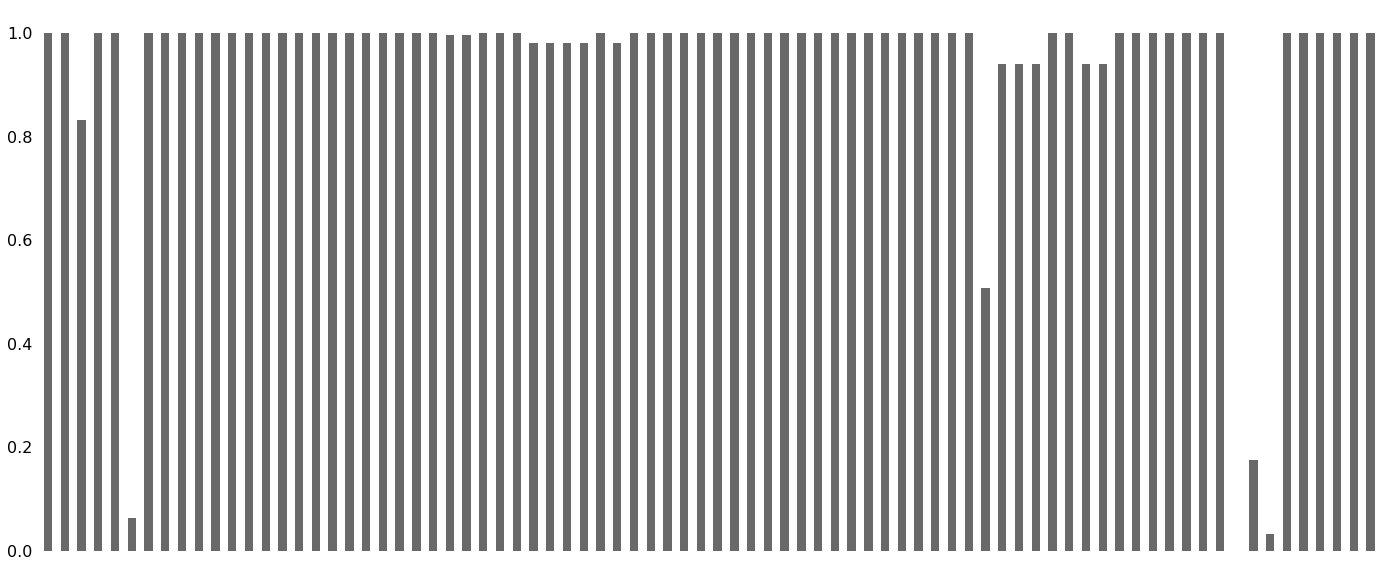

In [13]:
msno.bar(train.sample(250))

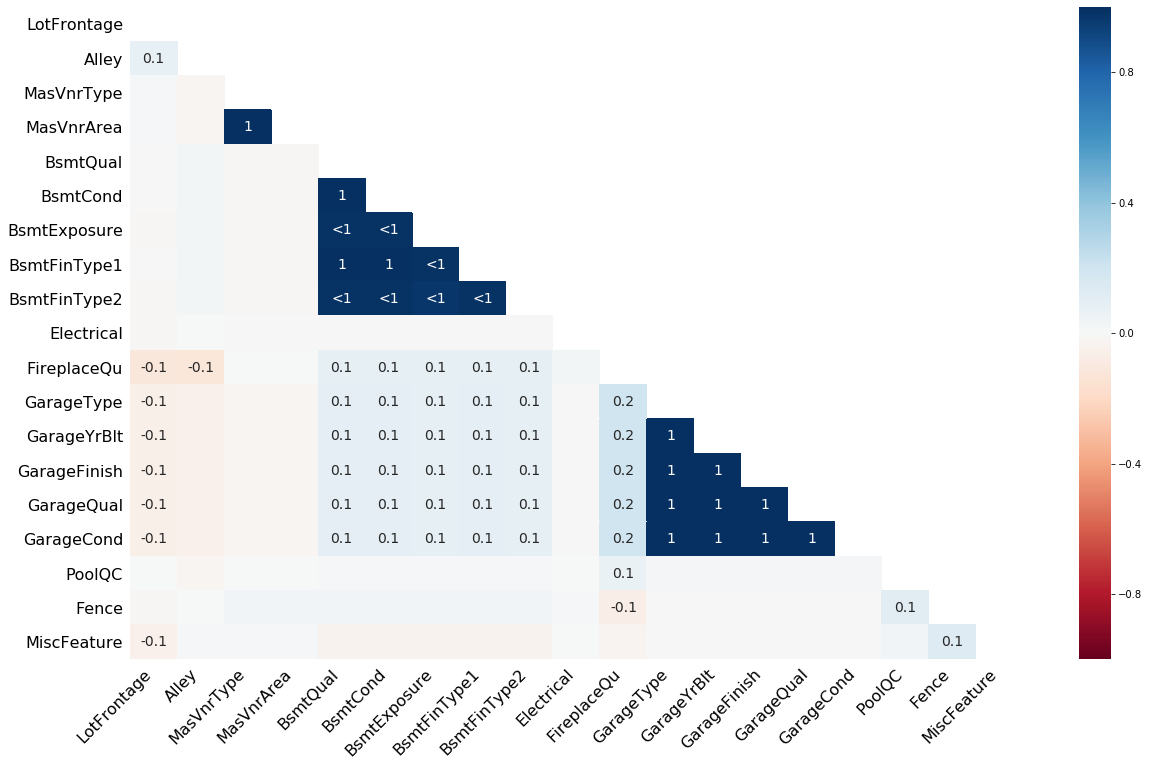

In [14]:
msno.heatmap(train)

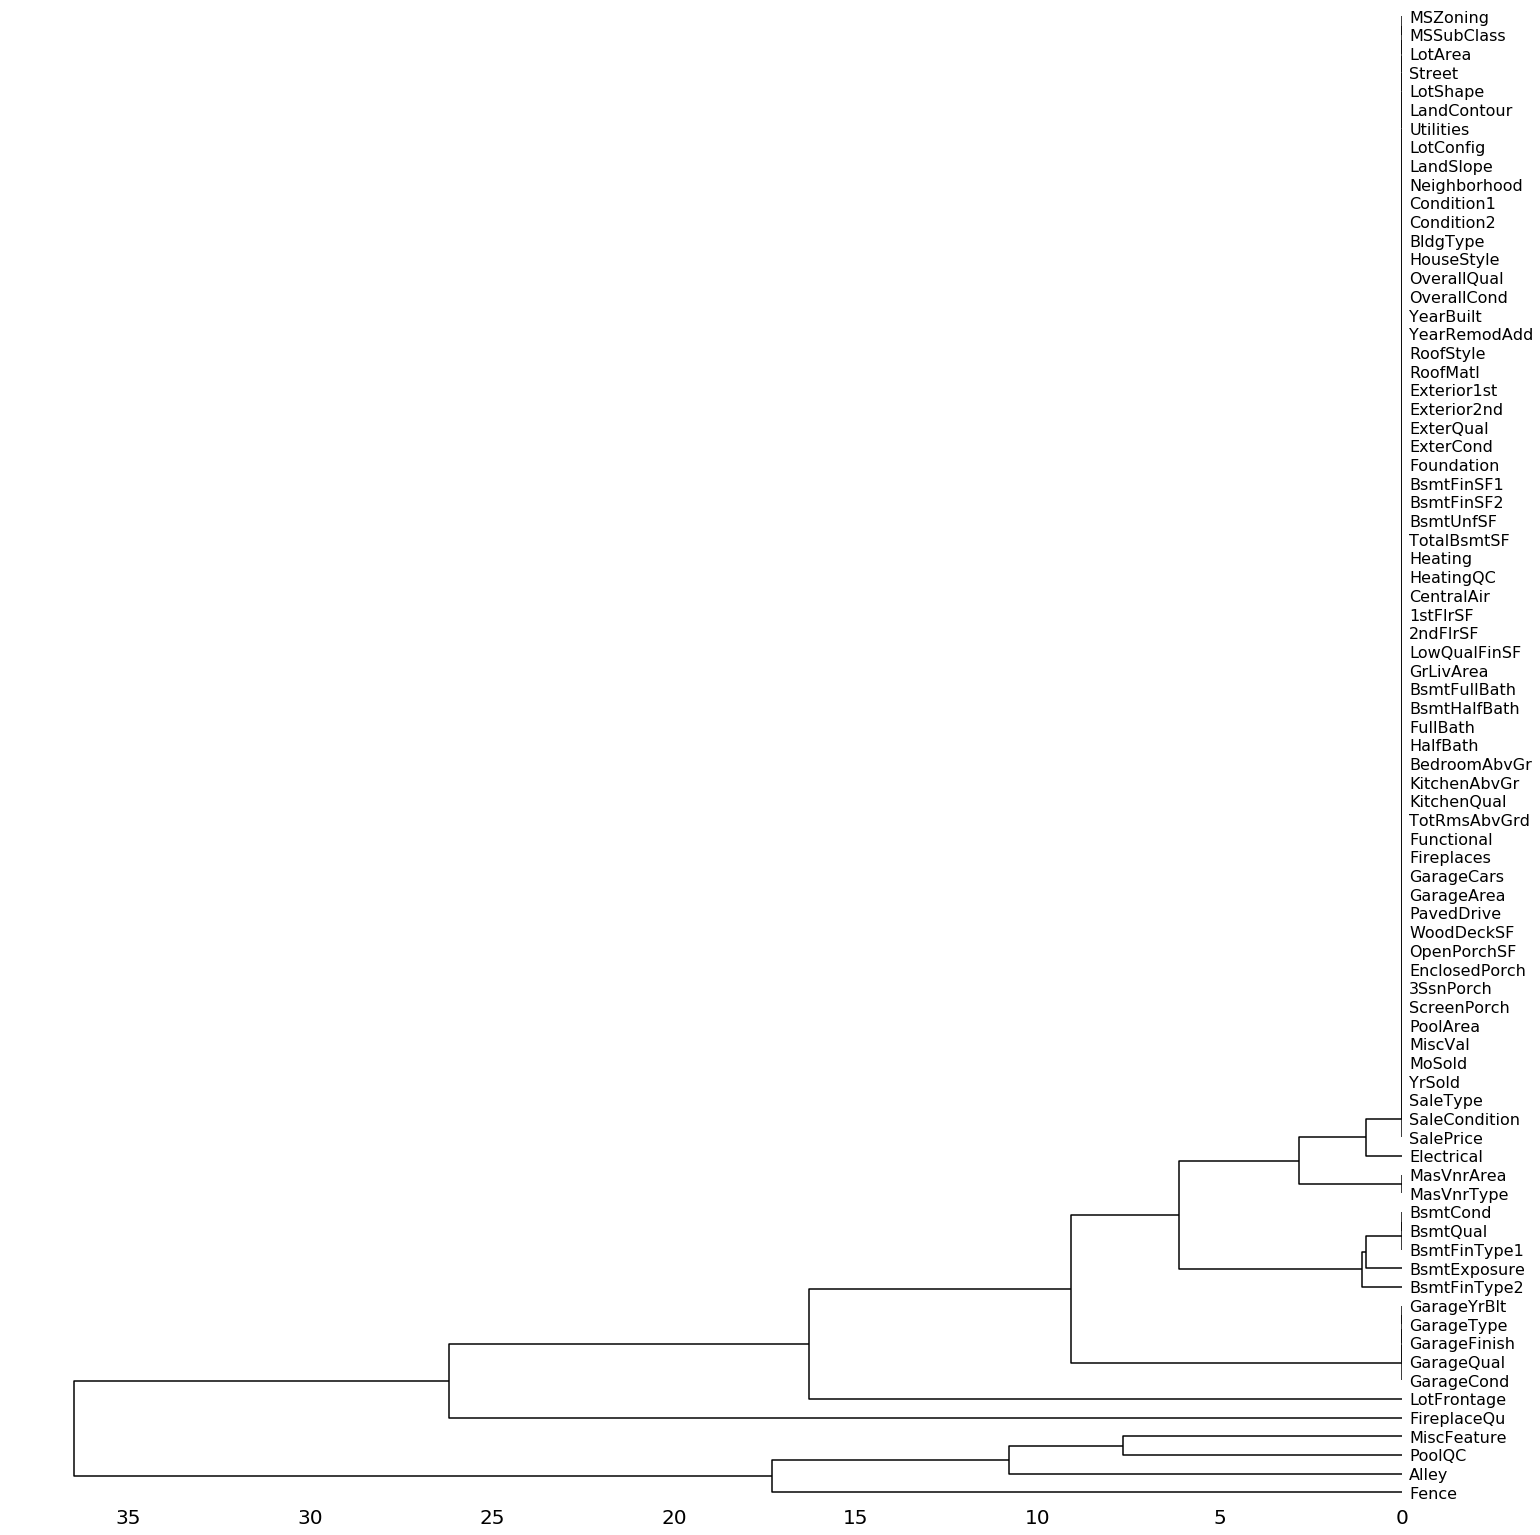

In [15]:
msno.dendrogram(train)

### Looking at Skewness and Kurtosis

In [16]:
train.skew(), train.kurt()

(MSSubClass        1.407657
 LotFrontage       2.163569
 LotArea          12.207688
 OverallQual       0.216944
 OverallCond       0.693067
 YearBuilt        -0.613461
 YearRemodAdd     -0.503562
 MasVnrArea        2.669084
 BsmtFinSF1        1.685503
 BsmtFinSF2        4.255261
 BsmtUnfSF         0.920268
 TotalBsmtSF       1.524255
 1stFlrSF          1.376757
 2ndFlrSF          0.813030
 LowQualFinSF      9.011341
 GrLivArea         1.366560
 BsmtFullBath      0.596067
 BsmtHalfBath      4.103403
 FullBath          0.036562
 HalfBath          0.675897
 BedroomAbvGr      0.211790
 KitchenAbvGr      4.488397
 TotRmsAbvGrd      0.676341
 Fireplaces        0.649565
 GarageYrBlt      -0.649415
 GarageCars       -0.342549
 GarageArea        0.179981
 WoodDeckSF        1.541376
 OpenPorchSF       2.364342
 EnclosedPorch     3.089872
 3SsnPorch        10.304342
 ScreenPorch       4.122214
 PoolArea         14.828374
 MiscVal          24.476794
 MoSold            0.212053
 YrSold            0

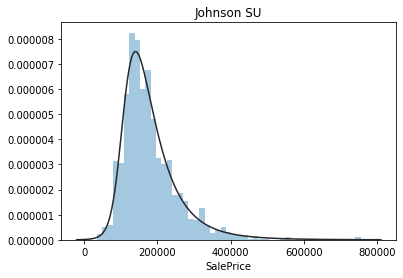

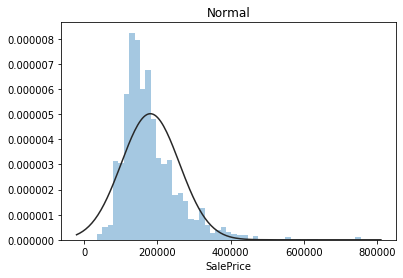

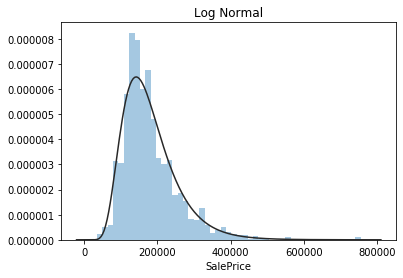

In [17]:
y = train['SalePrice']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

From the graphs, it is evident that this is not a normal distribution. We will have to transform the data before performing a regression. The best fit is unbounded Johnson distribution.

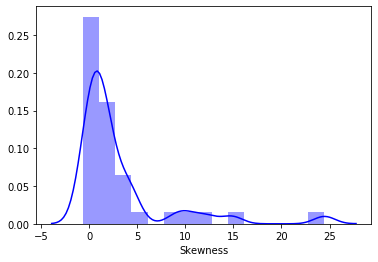

In [18]:
sns.distplot(train.skew(),color='blue',axlabel='Skewness')

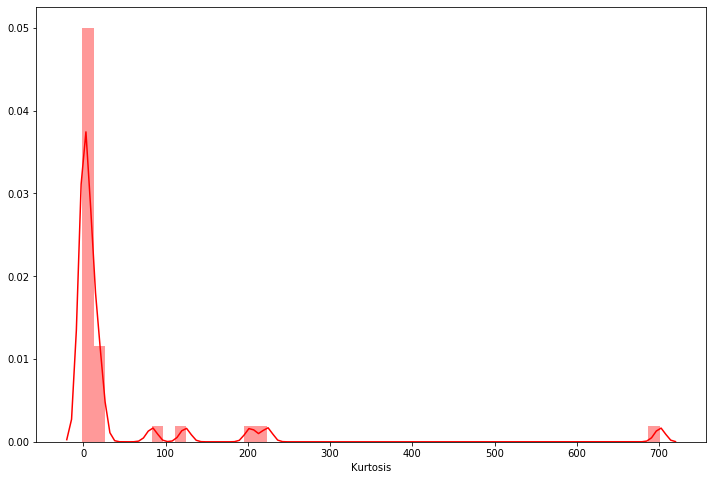

In [19]:
plt.figure(figsize = (12,8))
sns.distplot(train.kurt(),color='r',axlabel ='Kurtosis',norm_hist= False, kde = True,rug = False)
plt.show()

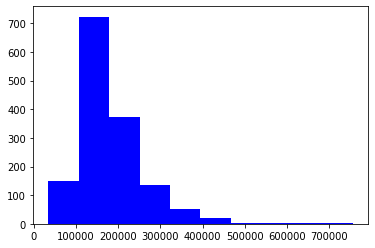

In [20]:
plt.hist(train['SalePrice'],orientation = 'vertical',histtype = 'bar', color = 'blue')
plt.show()

(array([  5.,  12.,  54., 184., 470., 400., 220.,  90.,  19.,   6.]),
 array([10.46024211, 10.7676652 , 11.07508829, 11.38251138, 11.68993448,
        11.99735757, 12.30478066, 12.61220375, 12.91962684, 13.22704994,
        13.53447303]),
 <a list of 10 Patch objects>)

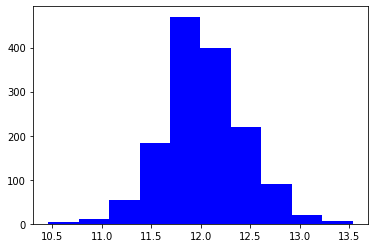

In [21]:
# Taking the log of saleprice
target = np.log(train['SalePrice'])
target.skew
plt.hist(target,color='blue')

Next we will look at a correlation heat map, zoomed heat map, pair plot, and scatter plot. 

In [22]:
# Using the .corr() method to see correlation with 'SalePrice'
correlation = num_features.corr()
print(correlation['SalePrice'].sort_values(ascending = False),'\n')

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64 



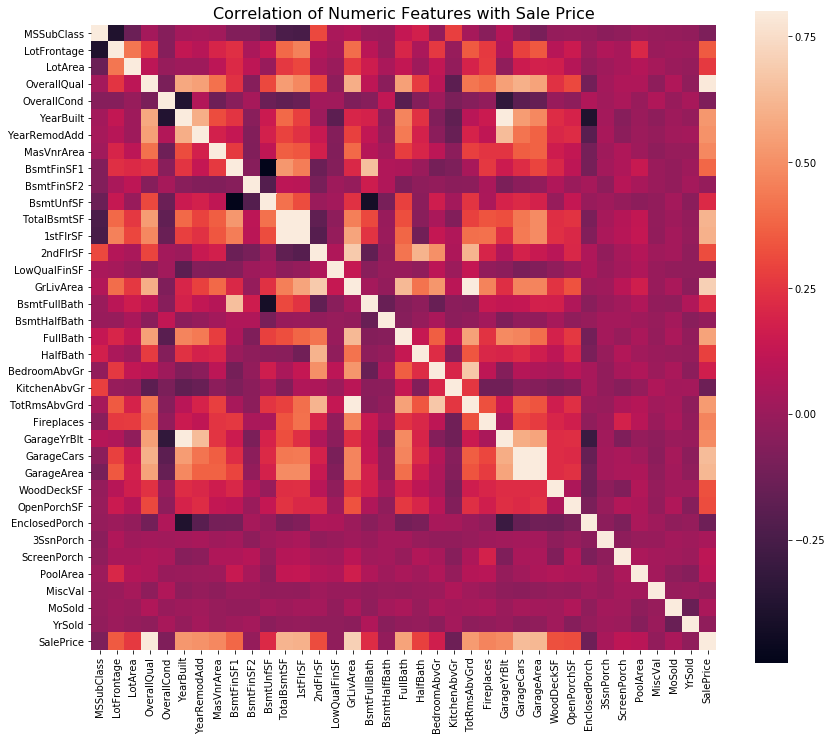

In [23]:
# Correlation Heat Map
f, ax = plt.subplots(figsize = (14,12))

plt.title('Correlation of Numeric Features with Sale Price', y=1, size=16)

sns.heatmap(correlation,square=True,vmax=0.8)

There are two distinct squares. One referring to 'TotalBsmtSF' and '1stFlrSF'. Another one referring to 'GarageX' variable. Also notice 'GrLivArea', 'TotalBsmtSF', and 'OverallQual' are corellated to 'SalePrice'.

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
       'YearRemodAdd'],
      dtype='object')


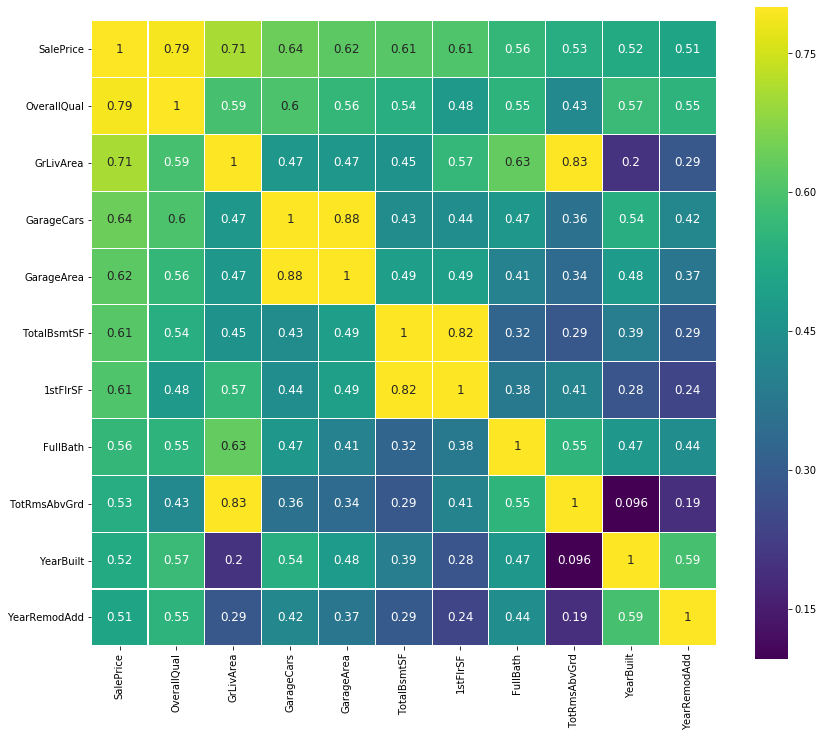

In [24]:
# Zoomed HeatMap
k = 11
cols = correlation.nlargest(k,'SalePrice')['SalePrice'].index
print(cols)
cm = np.corrcoef(train[cols].values.T)
f, ax = plt.subplots(figsize = (14, 12))
sns.heatmap(cm, vmax=.8, linewidths=0.01, square=True, annot=True, cmap='viridis',
           linecolor='white',xticklabels = cols.values, annot_kws = {'size':12},yticklabels = cols.values)

The zoomed heatmap shows that GarageCars and GarageArea are closely correlated. TotalBsmtSF and 1stFlrSF are also closely correlated. 

Observations: 
* There is strong correlation between 'GrLivArea', 'TotalBsmtSF', and 'SalePrice'
* Only need to keep 'GarageArea' or 'GarageCars' as they convey the same information. Keep 'GarageCars' since it has higher correlation.
* 'TotalBsmtSF' and '1stFoorSF' also seem to be twins. We will keep 'TotalBsmtSF'
* 'TotRmsAbvGrd' and 'GrLivArea' are twins.

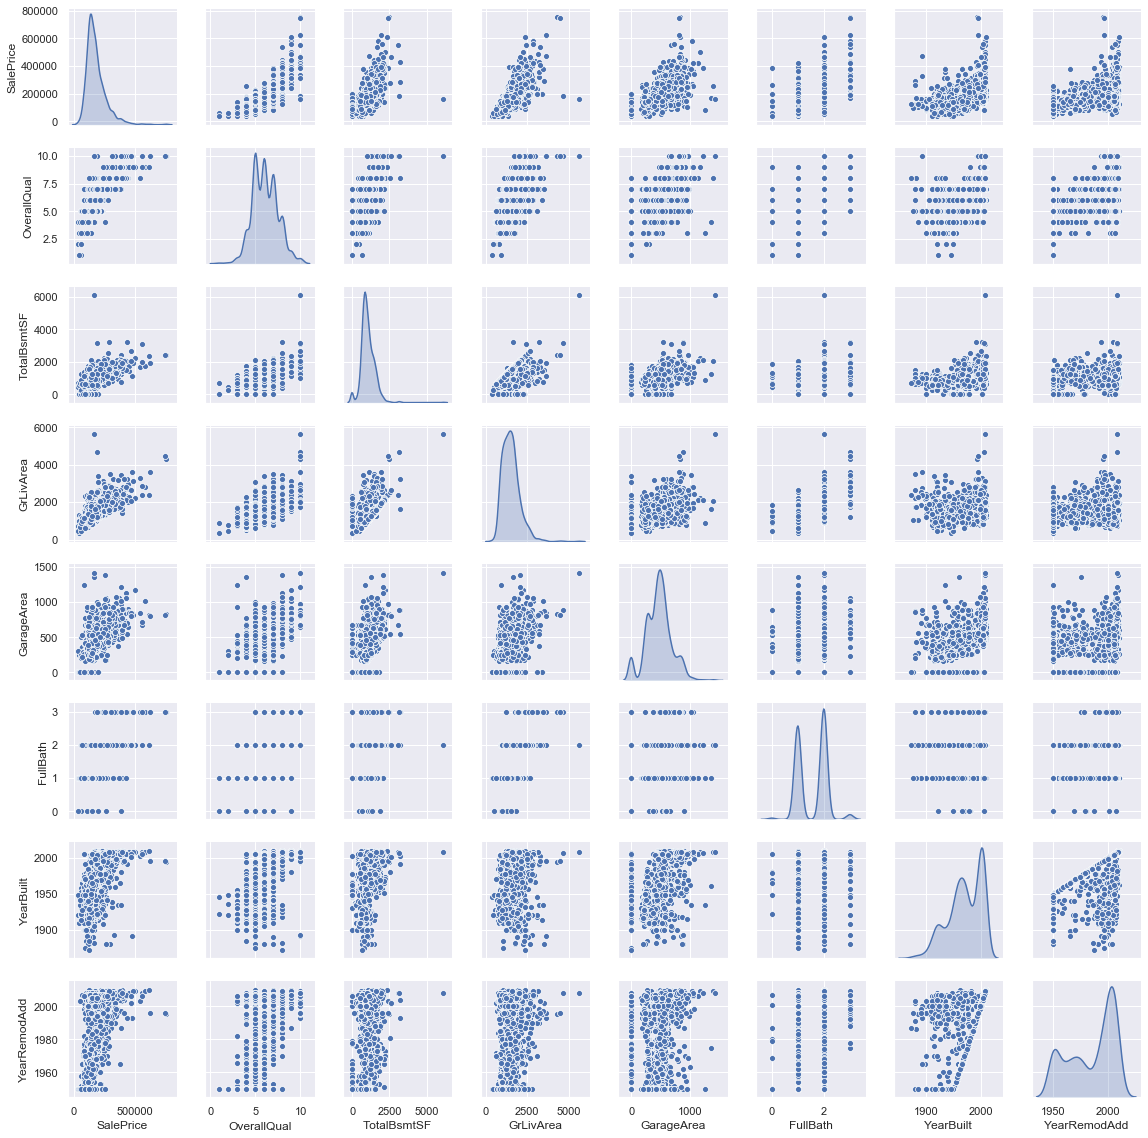

In [25]:
# Pair Plot
sns.set()
columns = ['SalePrice','OverallQual','TotalBsmtSF','GrLivArea','GarageArea','FullBath','YearBuilt','YearRemodAdd']
sns.pairplot(train[columns],size = 2 ,kind ='scatter',diag_kind='kde')
plt.show()

* Relationships apparent between 'TotalBsmtSF' and 'GrLiveArea'. This makes sense as they would likely be related. 
* 'SalePrice' and 'YearBuilt' seem to have an exponential relationship.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


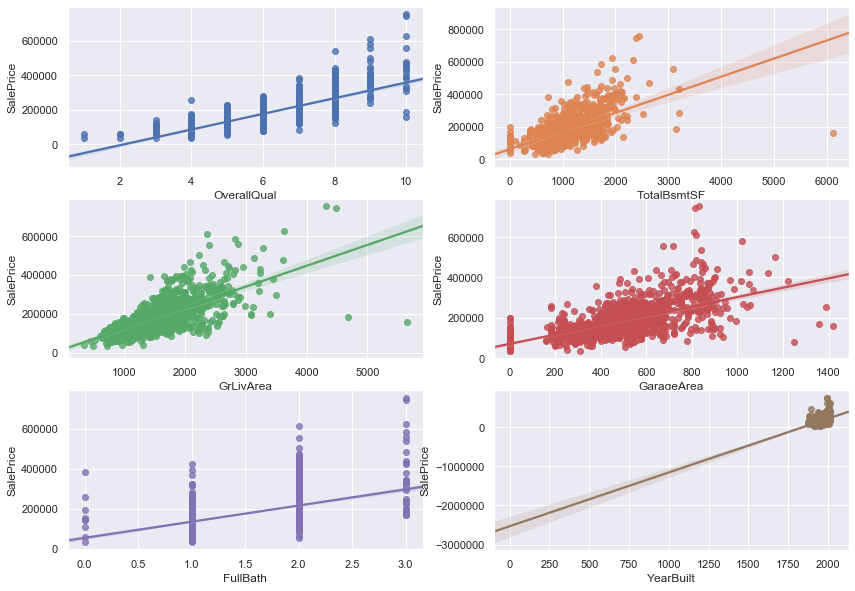

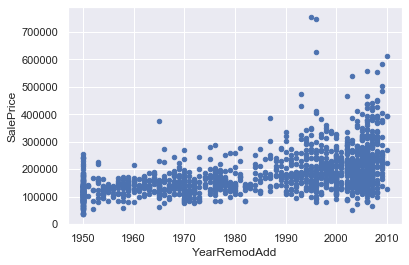

In [26]:
# Scatter Plots
fig, ((ax1, ax2), (ax3, ax4),(ax5,ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(14,10))
OverallQual_scatter_plot = pd.concat([train['SalePrice'],train['OverallQual']],axis = 1)
sns.regplot(x='OverallQual',y = 'SalePrice',data = OverallQual_scatter_plot,scatter= True, fit_reg=True, ax=ax1)
TotalBsmtSF_scatter_plot = pd.concat([train['SalePrice'],train['TotalBsmtSF']],axis = 1)
sns.regplot(x='TotalBsmtSF',y = 'SalePrice',data = TotalBsmtSF_scatter_plot,scatter= True, fit_reg=True, ax=ax2)
GrLivArea_scatter_plot = pd.concat([train['SalePrice'],train['GrLivArea']],axis = 1)
sns.regplot(x='GrLivArea',y = 'SalePrice',data = GrLivArea_scatter_plot,scatter= True, fit_reg=True, ax=ax3)
GarageArea_scatter_plot = pd.concat([train['SalePrice'],train['GarageArea']],axis = 1)
sns.regplot(x='GarageArea',y = 'SalePrice',data = GarageArea_scatter_plot,scatter= True, fit_reg=True, ax=ax4)
FullBath_scatter_plot = pd.concat([train['SalePrice'],train['FullBath']],axis = 1)
sns.regplot(x='FullBath',y = 'SalePrice',data = FullBath_scatter_plot,scatter= True, fit_reg=True, ax=ax5)
YearBuilt_scatter_plot = pd.concat([train['SalePrice'],train['YearBuilt']],axis = 1)
sns.regplot(x='YearBuilt',y = 'SalePrice',data = YearBuilt_scatter_plot,scatter= True, fit_reg=True, ax=ax6)
YearRemodAdd_scatter_plot = pd.concat([train['SalePrice'],train['YearRemodAdd']],axis = 1)
YearRemodAdd_scatter_plot.plot.scatter('YearRemodAdd','SalePrice')

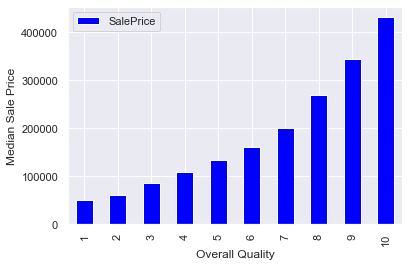

In [27]:
# Looking at Overall Quality vs Median Sale Price
saleprice_overall_quality= train.pivot_table(index ='OverallQual',values = 'SalePrice', aggfunc = np.median)
saleprice_overall_quality.plot(kind = 'bar',color = 'blue')
plt.xlabel('Overall Quality')
plt.ylabel('Median Sale Price')
plt.show()

### Looking at Box Plots

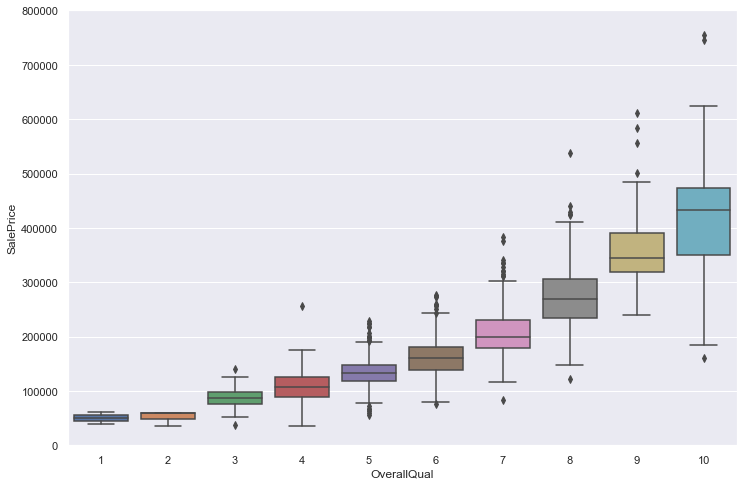

In [28]:
# Overall Quality
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(12, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

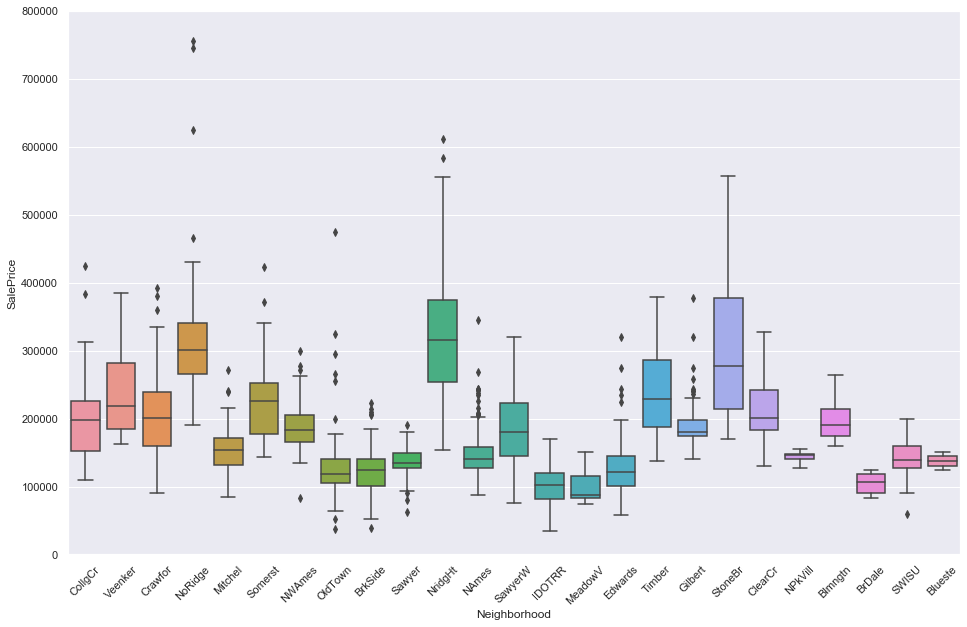

In [29]:
# Neighborhood
var = 'Neighborhood'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 10))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
xt = plt.xticks(rotation = 45)

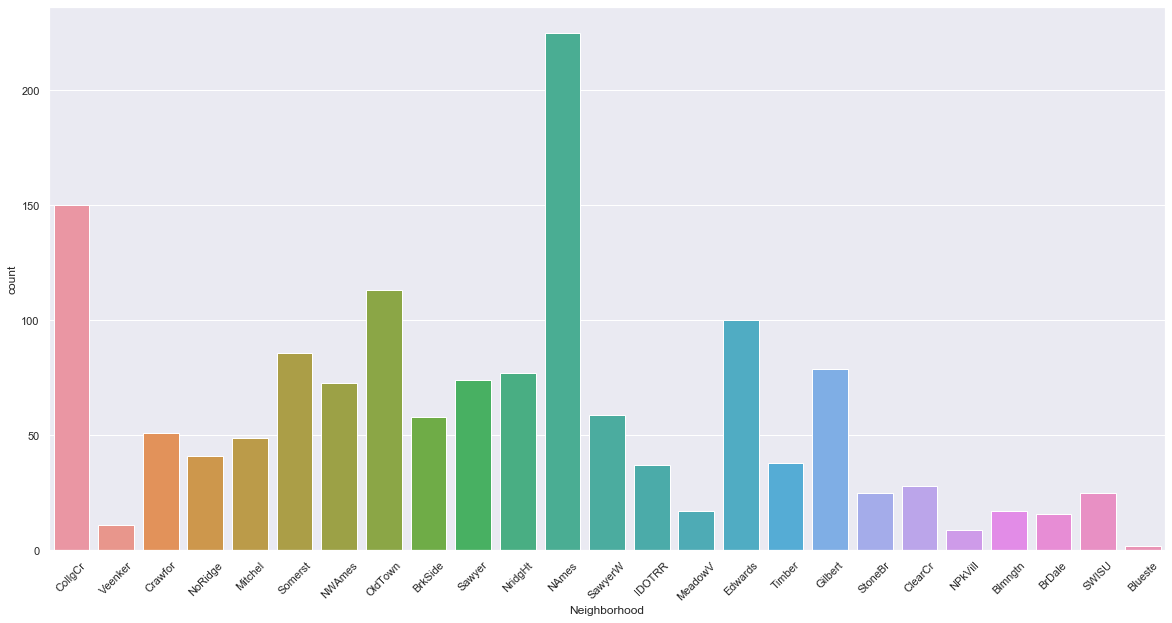

In [30]:
# Count Plot - Neighborhood
plt.figure(figsize = (20,10))
sns.countplot(x = 'Neighborhood', data = data)
xt = plt.xticks(rotation=45)

With Qualitative variables we can check distribution of SalePrice with respect to categorical variables.

for c in cat_features:
    train[c] = train[c].astype('category')
    if train[c].isnull().any():
        train[c] = train[c].cat.add_categories(['MISSING'])
        train[c] = train[c].fillna('MISSING')

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(train, id_vars=['SalePrice'], value_vars=cat_features)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "SalePrice")

### Missing Value Analysis

# Numeric Features
total = num_features.isnull().sum().sort_values(ascending=False)
percent = (num_features.isnull().sum()/num_features.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis = 1, join='outer', keys=['Total Missing Count', '% of Total Observations'])
missing_data.index.name = ' Numeric Feature'

missing_data.head(20)

# Creating a Plot
missing_values = num_features.isnull().sum(axis=0).reset_index()
missing_values.columns = ['column_name', 'missing_count']
missing_values = missing_values.loc[missing_values['missing_count']>0]
missing_values = missing_values.sort_values(by='missing_count')

ind = np.arange(missing_values.shape[0])
width = 0.1
fig, ax = plt.subplots(figsize=(12,3))
rects = ax.barh(ind, missing_values.missing_count.values, color='b')
ax.set_yticks(ind)
ax.set_yticklabels(missing_values.column_name.values, rotation='horizontal')
ax.set_xlabel("Missing Observations Count")
ax.set_title("Missing Observations Count - Numeric Features")
plt.show()

# Categorical Features
missing_values = cat_features.isnull().sum(axis=0).reset_index()
missing_values.columns = ['column_name', 'missing_count']
missing_values = missing_values.loc[missing_values['missing_count']>0]
missing_values = missing_values.sort_values(by='missing_count')

ind = np.arange(missing_values.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_values.missing_count.values, color='red')
ax.set_yticks(ind)
ax.set_yticklabels(missing_values.column_name.values, rotation='horizontal')
ax.set_xlabel("Missing Observations Count")
ax.set_title("Missing Observations Count - Categorical Features")
plt.show()

### Categorical Feature Exploration

# Categorical Feature Exploration
for column_name in train.columns:
    if train[column_name].dtypes == 'object':
        train[column_name] = train[column_name].fillna(train[column_name].mode().iloc[0])
        unique_category = len(train[column_name].unique())
        print("Feature '{column_name}' has '{unique_category}' unique categories".format(column_name = column_name,
                                                                                         unique_category=unique_category))
for column_name in test.columns:
    if test[column_name].dtypes == 'object':
        test[column_name] = test[column_name].fillna(test[column_name].mode().iloc[0])
        unique_category = len(test[column_name].unique())
        print("Features in test set '{column_name}' has '{unique_category}' unique categories".format(column_name = column_name, unique_category=unique_category))    

## Analyzing the Test Variable (Sale Price)

In [31]:
# Description of Saleprice
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


 mu = 180921.20 and sigma = 79415.29



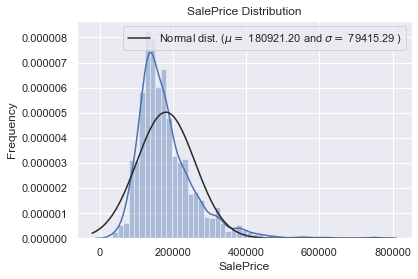

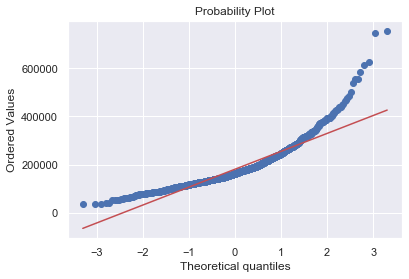

Skewness: 1.882876
Kurtosis: 6.536282


In [32]:
# Plot Histogram
sns.distplot(train['SalePrice'], fit = norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu,sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu,sigma)],
          loc = 'best')

plt.ylabel('Frequency')
plt.title('SalePrice Distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot = plt)
plt.show()

print('Skewness: %f' % train['SalePrice'].skew())
print('Kurtosis: %f' % train['SalePrice'].kurt())

It is clear sale prices do not follow the normat distribution. We will fix this down the road!

Let's check the types of data

In [33]:
# Check for Categorical Data
train.select_dtypes(include = ['object']).columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [34]:
# Check for Numerical Data
train.select_dtypes(include = ['int64', 'float64']).columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [35]:
cat = len(train.select_dtypes(include = ['object']).columns)
num = len(train.select_dtypes(include = ['int64', 'float64']).columns)

print('Total Features: ', cat, 'categorical', '+', num, 'numerical', '=', cat+num, 'features')

Total Features:  43 categorical + 37 numerical = 80 features


## Multivariate Analysis

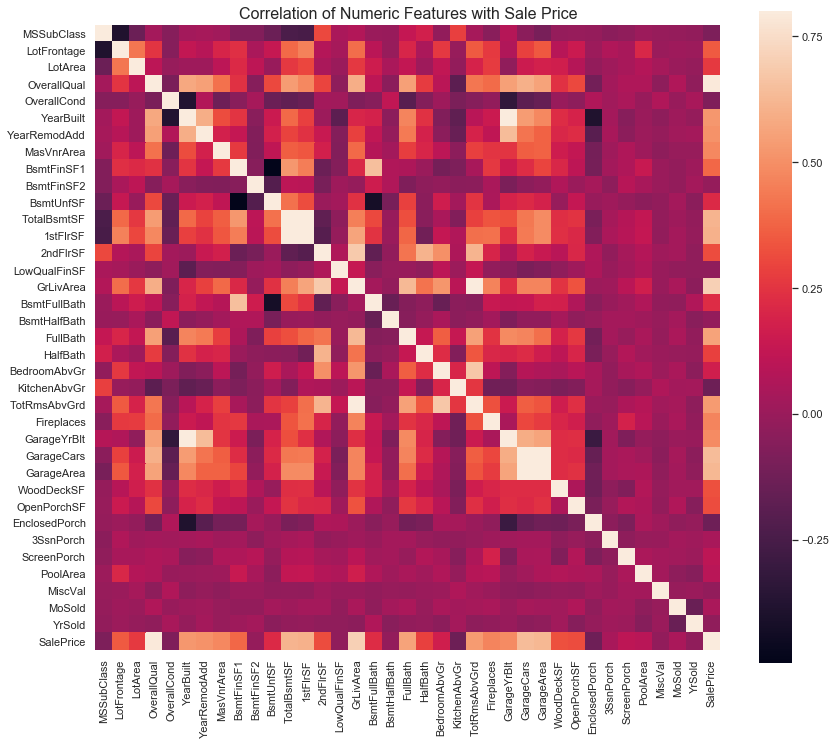

In [36]:
# Correlation Heat Map
f, ax = plt.subplots(figsize = (14,12))

plt.title('Correlation of Numeric Features with Sale Price', y=1, size=16)

sns.heatmap(correlation,square=True,vmax=0.8)

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
       'YearRemodAdd'],
      dtype='object')


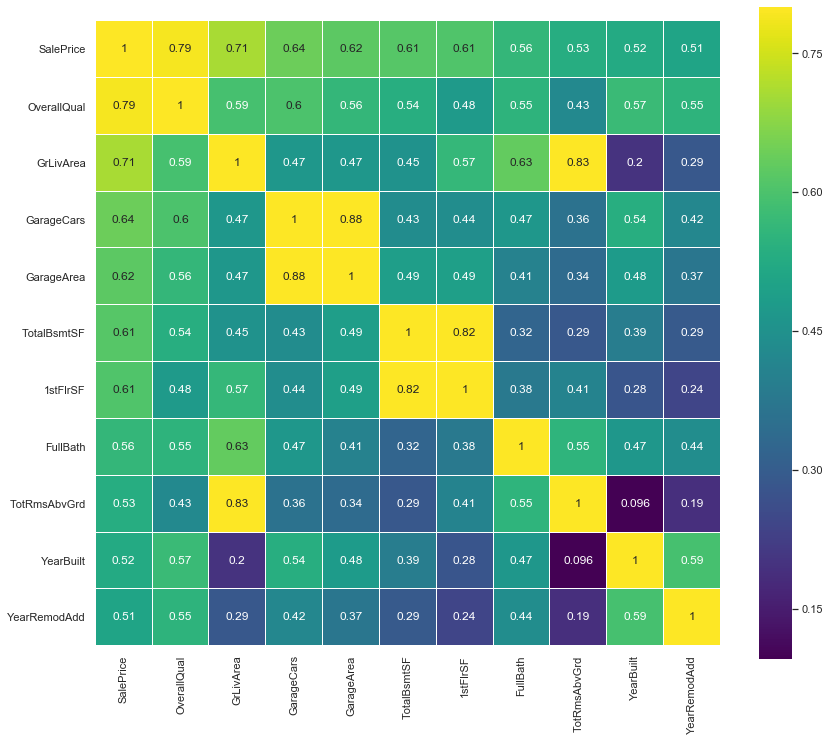

In [37]:
# Zoomed HeatMap
k = 11
cols = correlation.nlargest(k,'SalePrice')['SalePrice'].index
print(cols)
cm = np.corrcoef(train[cols].values.T)
f, ax = plt.subplots(figsize = (14, 12))
sns.heatmap(cm, vmax=.8, linewidths=0.01, square=True, annot=True, cmap='viridis',
           linecolor='white',xticklabels = cols.values, annot_kws = {'size':12},yticklabels = cols.values)

In [38]:
most_corr = pd.DataFrame(cols)
most_corr.columns = ['Most Correlated Features']
most_corr

,Most Correlated Features
0,SalePrice
1,OverallQual
2,GrLivArea
3,GarageCars
4,GarageArea
5,TotalBsmtSF
6,1stFlrSF
7,FullBath
8,TotRmsAbvGrd
9,YearBuilt


Now let's look at each feature and how it relates to Sale Price and do some feature engineering. 

### Overall Quality vs Sale Price

(-0.5, 9.5, 0, 800000)

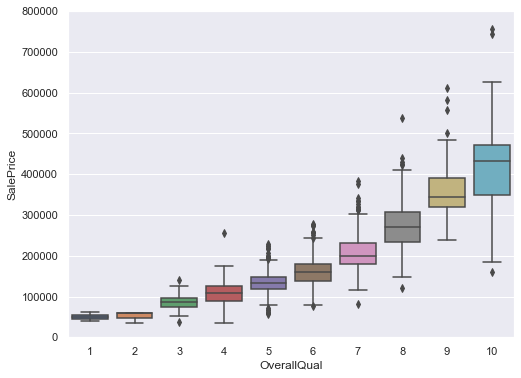

In [39]:
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train[var]], axis = 1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x=var, y='SalePrice', data=data)
fig.axis(ymin=0, ymax=800000)

This shows something we expected, homes in better condition sell for higher prices. 

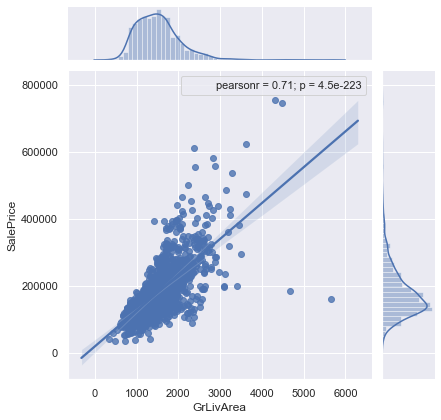

In [40]:
f = sns.jointplot(x=train['GrLivArea'], y=train['SalePrice'], kind='reg')
f.annotate(stats.pearsonr)

Just as expected, SalePrice goes up as the living area increases.
* Note there are some outliers in the bottom right so we will remove these since they are anomolies

In [41]:
# Removing the Outliers
train = train.drop(train[(train['GrLivArea']>4000) 
                        & (train['SalePrice']<300000)].index).reset_index(drop=True)

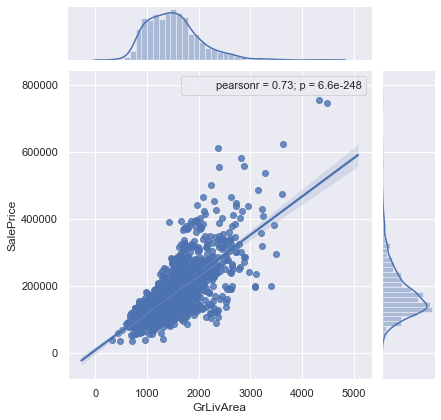

In [42]:
# Plotting again
f = sns.jointplot(x=train['GrLivArea'], y=train['SalePrice'], kind='reg')
f.annotate(stats.pearsonr)

Notice the r score improved by 0.02 after the outliers were removed from the data set. 

(-0.5, 4.5, 0, 800000)

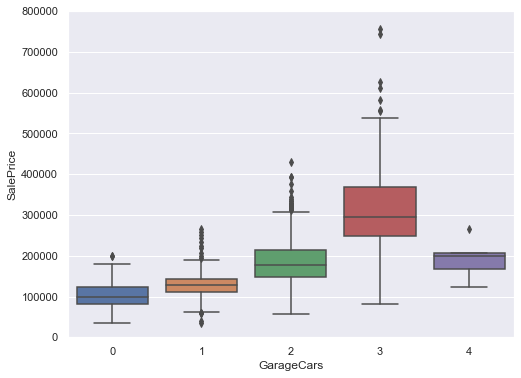

In [43]:
var = 'GarageCars'
data = pd.concat([train['SalePrice'], train[var]], axis = 1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x=var, y='SalePrice', data=data)
fig.axis(ymin=0, ymax=800000)

There definitely are some outliers for GarageCars. A 4 car garage should not result in less Sale price

In [44]:
# Removing Outliers
train = train.drop(train[(train['GarageCars']>3)
                        & (train['SalePrice']<300000)].index).reset_index(drop=True)

(-0.5, 3.5, 0, 800000)

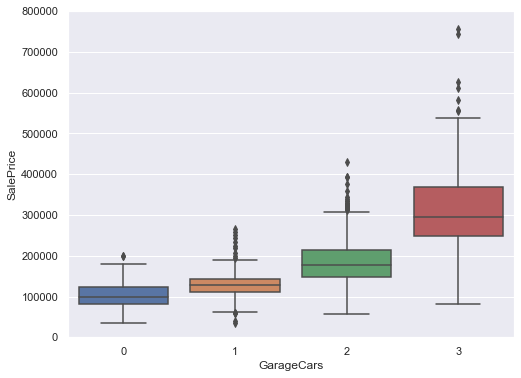

In [45]:
var = 'GarageCars'
data = pd.concat([train['SalePrice'], train[var]], axis = 1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x=var, y='SalePrice', data=data)
fig.axis(ymin=0, ymax=800000)

This makes more sense. GarageCars looks clean.

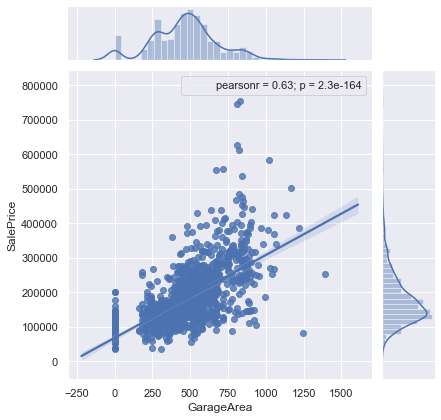

In [46]:
f = sns.jointplot(x=train['GarageArea'], y=train['SalePrice'], kind='reg')
f.annotate(stats.pearsonr)

Saleprice looks like it increases with GarageArea. There are a couple outliers in the bottom right so let's remove these.

In [47]:
# Dropping the outliers
train = train.drop(train[(train['GarageArea']>1000)
                        & (train['SalePrice']<300000)].index).reset_index(drop=True)

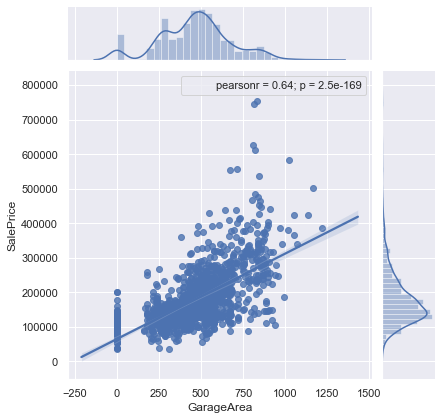

In [48]:
# Plotting again
f = sns.jointplot(x=train['GarageArea'], y=train['SalePrice'], kind='reg')
f.annotate(stats.pearsonr)

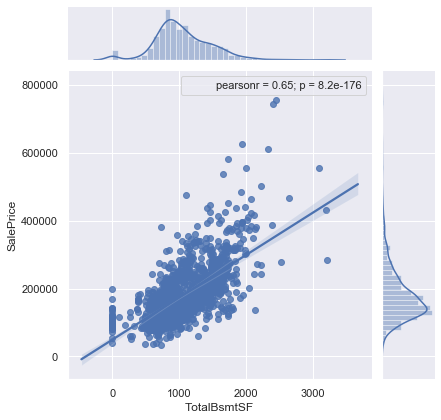

In [49]:
# Basement Area vs Sale Price
f = sns.jointplot(x=train['TotalBsmtSF'], y=train['SalePrice'], kind='reg')
f.annotate(stats.pearsonr)

'TotalBsmtSF' does not appear to have any significant outliers that defy the trend.

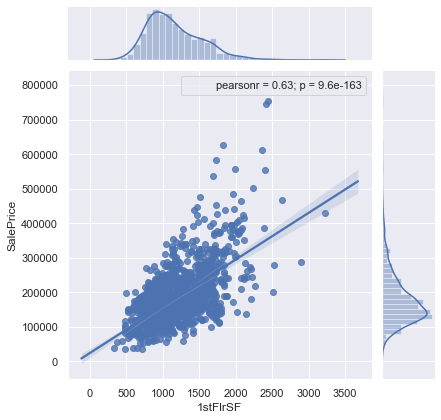

In [50]:
# 1stFlrSF vs Sale Price
f = sns.jointplot(x=train['1stFlrSF'], y=train['SalePrice'], kind='reg')
f.annotate(stats.pearsonr)

'1stFlrSF' also looks good.

(-0.5, 3.5, 0, 800000)

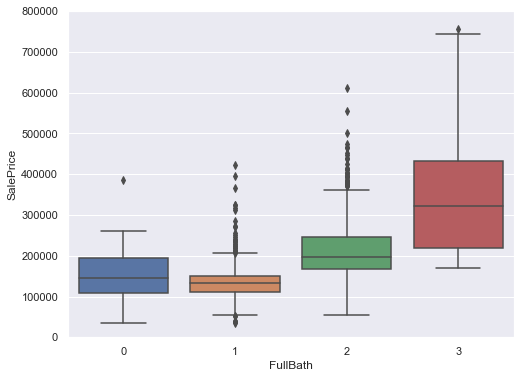

In [51]:
# Looking at Fullbath vs SalePrice
var = 'FullBath'
data = pd.concat([train['SalePrice'], train[var]], axis = 1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x=var, y='SalePrice', data=data)
fig.axis(ymin=0, ymax=800000)


(-0.5, 11.5, 0, 800000)

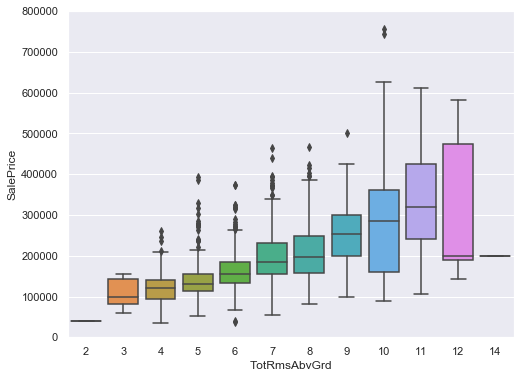

In [52]:
# TotRmsAbvGrd vs SalePrice
var = 'TotRmsAbvGrd'
data = pd.concat([train['SalePrice'], train[var]], axis = 1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x=var, y='SalePrice', data=data)
fig.axis(ymin=0, ymax=800000)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111]),
 <a list of 112 Text xticklabel objects>)

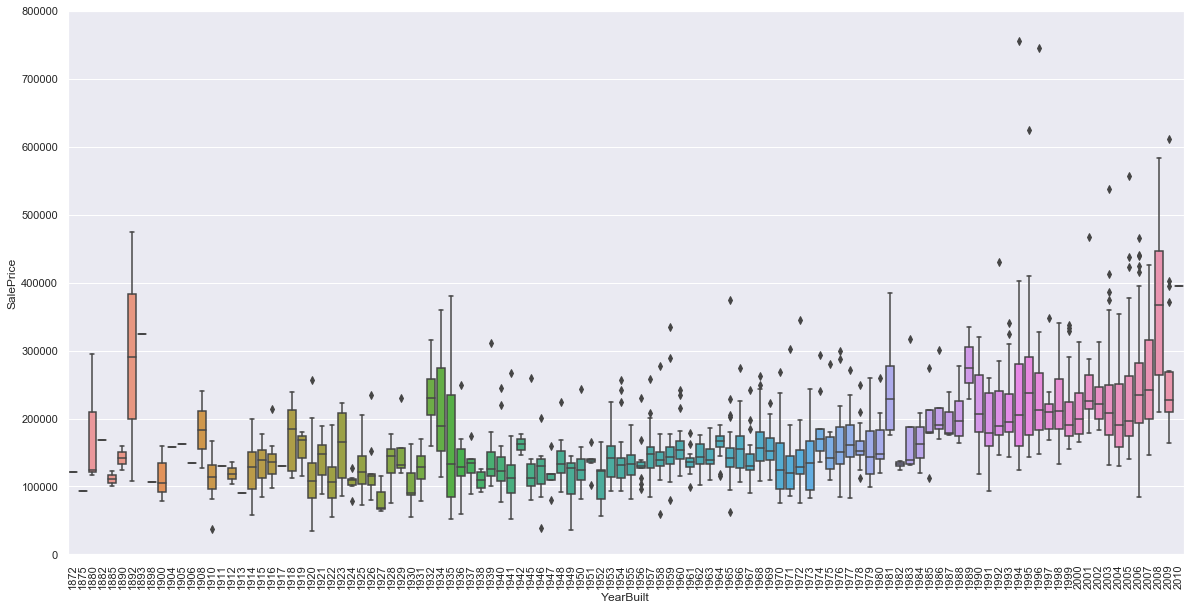

In [53]:
# YearBuilt vs SalePrice
var = 'YearBuilt'
data = pd.concat([train['SalePrice'], train[var]], axis = 1)
f, ax = plt.subplots(figsize=(20,10))
fig = sns.boxplot(x=var, y='SalePrice', data=data)
fig.axis(ymin=0, ymax=800000)
plt.xticks(rotation='vertical')

## Taking Care of Missing Data
To take care of missing data we will perform two steps.
1. Check how much data is missing and is there a pattern?
2. Fill in values for missing data or delete the specific instance

To make our lives easier we will combine the training and test data into one dataset

In [54]:
# Combining the datasets
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values

full_data = pd.concat((train, test)).reset_index(drop=True)
# full_data.drop(['SalePrice'], axis = 1, inplace=True)
print('Train data size is: {}'.format(train.shape))
print('Test data size is: {}'.format(test.shape))
print('Combined dataseet size is: {}'.format(full_data.shape))

Train data size is: (1448, 80)
Test data size is: (1459, 79)
Combined dataseet size is: (2907, 80)


In [55]:
# Find Missing Ratio of Dataset
full_data_na = (full_data.isnull().sum() / len(full_data)) * 100
full_data_na = full_data_na.drop(full_data_na[full_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :full_data_na})
missing_data

,Missing Ratio
PoolQC,99.690402
MiscFeature,96.422429
Alley,93.223254
Fence,80.392157
SalePrice,50.189198
FireplaceQu,48.710010
LotFrontage,16.683867
GarageQual,5.469556
GarageCond,5.469556
GarageFinish,5.469556


Text(0.5, 1.0, 'Percent missing data by feature')

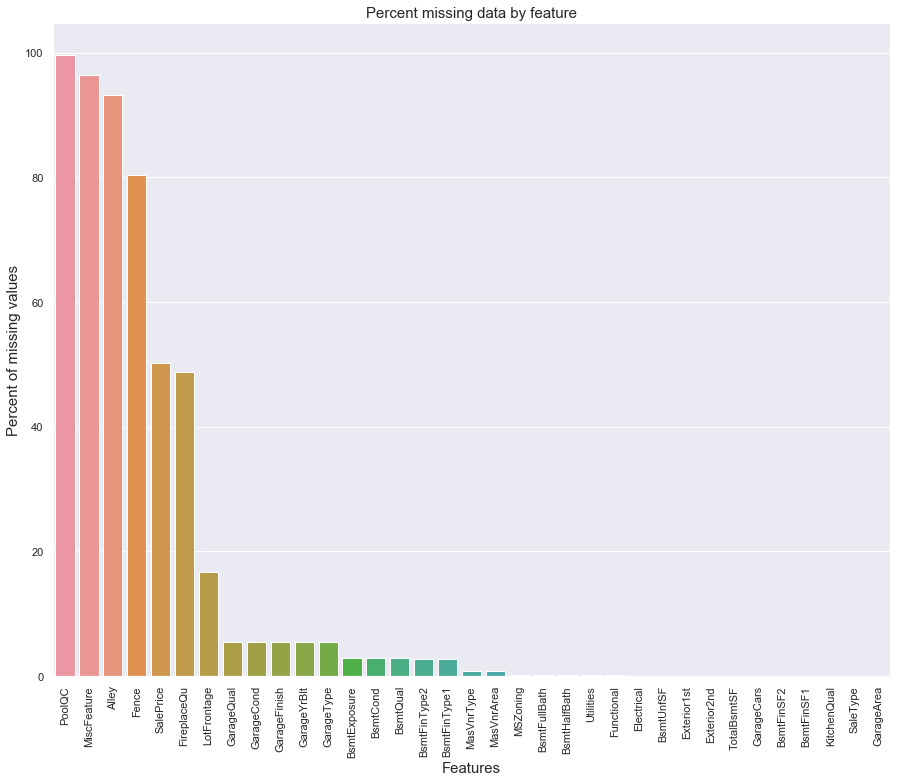

In [56]:
# Percent missing data by feature
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=full_data_na.index, y=full_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

## Inserting Missing Values

From the data description file we can choose to fill the missing value with an averge or value that makes logical sense.
* **PoolQC** -> Missing values will be filled with NA which stands for No Pool
* **MiscFeature** -> Missing values will be filled with NA for None
* **Alley** -> Missing values will be filled with NA for No alley access
* **Fence** -> Missing values will be filled with NA for No Fence
* **FireplaceQu** -> Missing values will be filled with NA for No Fireplace
* **LotFrontage** -> We will use the median LotFrontage of the neighborhood
* **GarageQual** -> Missing values will be filled with NA for No Garage
* **GarageCond** -> Missing values will be filled with NA for No Garage
* **GarageFinish** -> Missing values will be filled with NA for No Garage
* **GarageYrBlt** -> Missing values will be filled with NA for No Garage
* **GarageType** -> Missing values will be filled with NA for No Garage
* **BsmtExposure** -> Missing values will be filled with NA for No Basement
* **BsmtCond** -> Missing values will be filled with NA for No Basement
* **BsmtQual** -> Missing values will be filled with NA for No Basement
* **BsmtFinType2** -> Missing values will be filled with NA for No Basement
* **BsmtFinType1** -> Missing values will be filled with NA for No Basement
* **MasVnrType** -> Missing Values will be filled with None for None
* **MasVnrArea** -> Missing values will be filled with 0 for veneer area in sf
* **MSZoning** -> Missing values will be filled with RL since it is most common
* **BsmtFullBath** -> Missing values will be filled with 0 for number of bathrooms
* **BsmtHalfBath** -> Missing values will be filled with 0 for number of bathrooms
* **Utilities** -> This feature will be removed since all are All public except 4
* **Functional** -> Missing values will be filled with Typ for Typical Functionality
* **Electrical** -> Missing values will be filled with SBrkr for Standard Circuit Breakers and Romex
* **BsmtUnfSF** -> Missing values will be filled with 0 for unfinished sf of basement area
* **Exterior1st** -> Only 1 missing value substitute in most common value
* **Exterior2nd** -> Only 1 missing value substitute in most common value
* **TotalBsmtSF** -> Missing values will be filled with 0 for unfinished sf of basement area
* **GarageArea** -> Missing values will be filled with 0 for 0 sf of garage area
* **GarageCars** -> Missing values will be filled in with 0 for 0 cars
* **SaleType** -> Missing values will be filled with WD as most common
* **KitchenQual** -> Missing values will be filled with TA for Typical/Average

In [57]:
# Substituting PoolQC missing values
full_data['PoolQC'] = full_data['PoolQC'].fillna('NA')

# Substituting MiscFeature
full_data['MiscFeature'] = full_data['MiscFeature'].fillna('NA')

# Substituting Alley missing values
full_data['Alley'] = full_data['Alley'].fillna('NA')

# Substituting Fence missing values
full_data['Fence'] = full_data['Fence'].fillna('NA')

# Substituing FireplaceQu missing values
full_data['FireplaceQu'] = full_data['FireplaceQu'].fillna('NA')

# Substituting LotFrontage missing values
full_data['LotFrontage'] = full_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# Substituting GarageQual missing values
full_data['GarageQual'] = full_data['GarageQual'].fillna('NA')

# Substituing GarageCond missing values
full_data['GarageCond'] = full_data['GarageCond'].fillna('NA')

# Substituting GaragFinish
full_data['GarageFinish'] = full_data['GarageFinish'].fillna('NA')

# Substituting GarageYrBlt 
full_data['GarageYrBlt'] = full_data['GarageYrBlt'].fillna('NA')

# Substituting GarageType
full_data['GarageType'] = full_data['GarageType'].fillna('NA')

# Substituting BsmtExposure missing values
full_data['BsmtExposure'] = full_data['BsmtExposure'].fillna('NA')

# BsmtCond
full_data['BsmtCond'] = full_data['BsmtCond'].fillna('NA')

# BsmtQual
full_data['BsmtQual'] = full_data['BsmtQual'].fillna('NA')

# BsmtFinType2
full_data['BsmtFinType2'] = full_data['BsmtFinType2'].fillna('NA')

# BsmtFinType1
full_data['BsmtFinType1'] = full_data['BsmtFinType1'].fillna('NA')

# MasVnrType
full_data['MasVnrType'] = full_data['MasVnrType'].fillna('None')

#MasVnrArea # Check Data types
full_data['MasVnrArea'] = full_data['MasVnrArea'].fillna(0)

# MSZoning
full_data['MSZoning'] = full_data['MSZoning'].fillna('RL')

# BsmtFullBath
full_data['BsmtFullBath'] = full_data['BsmtFullBath'].fillna(0)

# BsmtHalfBath
full_data['BsmtHalfBath'] = full_data['BsmtHalfBath'].fillna(0)

# Utilities -> Drop this column
full_data.drop(columns = ['Utilities'], inplace = True)

# Functional
full_data['Functional'] = full_data['Functional'].fillna('Typ')

# Electrical 
full_data['Electrical'] = full_data['Electrical'].fillna('SBrkr')

# BsmtUnfSF
full_data['BsmtUnfSF'] = full_data['BsmtUnfSF'].fillna(0)

# Exterior1st
full_data['Exterior1st'] = full_data['Exterior1st'].fillna(full_data['Exterior1st'].mode()[0])

# Exterior2nd
full_data['Exterior2nd'] = full_data['Exterior2nd'].fillna(full_data['Exterior2nd'].mode()[0])

# TotalBsmtSF
full_data['TotalBsmtSF'] = full_data['TotalBsmtSF'].fillna(0)

# GarageArea
full_data['GarageArea'] = full_data['GarageArea'].fillna(0)

# GarageCars
full_data['GarageCars'] = full_data['GarageCars'].fillna(0)

# Saletype
full_data['SaleType'] = full_data['SaleType'].fillna('WD')

# KitchenQual
full_data['KitchenQual'] = full_data['KitchenQual'].fillna('TA')

# BsmtFinSf2
full_data['BsmtFinSF2'] = full_data['BsmtFinSF2'].fillna(0)

# BsmtFinSF1
full_data['BsmtFinSF1'] = full_data['BsmtFinSF1'].fillna(0)

In [58]:
# Check for Missing data
full_data_na = (full_data.isnull().sum() / len(full_data)) * 100
full_data_na = full_data_na.drop(full_data_na[full_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :full_data_na})
missing_data


,Missing Ratio
SalePrice,50.189198


In [59]:
max(full_data.isnull().sum())

1459

## Feature Engineering

In [60]:
# Checking data types of each feature
pd.set_option('display.max_rows', 100)
full_data.dtypes

1stFlrSF           int64
2ndFlrSF           int64
3SsnPorch          int64
Alley             object
BedroomAbvGr       int64
BldgType          object
BsmtCond          object
BsmtExposure      object
BsmtFinSF1       float64
BsmtFinSF2       float64
BsmtFinType1      object
BsmtFinType2      object
BsmtFullBath     float64
BsmtHalfBath     float64
BsmtQual          object
BsmtUnfSF        float64
CentralAir        object
Condition1        object
Condition2        object
Electrical        object
EnclosedPorch      int64
ExterCond         object
ExterQual         object
Exterior1st       object
Exterior2nd       object
Fence             object
FireplaceQu       object
Fireplaces         int64
Foundation        object
FullBath           int64
Functional        object
GarageArea       float64
GarageCars       float64
GarageCond        object
GarageFinish      object
GarageQual        object
GarageType        object
GarageYrBlt       object
GrLivArea          int64
HalfBath           int64


Comparing the data type of each feature to the description in data_description.txt, we can see some features need to be transformed.
* MSSubClass is a categorical feature but shows as type int64
* MoSold is a categorical feature but shows as type int64
* YrSold is a categorical feature but shows as type int 64
* OverallCond is a categorical feature but shows as type int64
* OverallQual is a categorical feature but shows as type int64


In [61]:
full_data['MSSubClass'].describe()

count    2907.000000
mean       57.094943
std        42.510238
min        20.000000
25%        20.000000
50%        50.000000
75%        70.000000
max       190.000000
Name: MSSubClass, dtype: float64

In [62]:
# Performing feature transformation on MSSubClass 
full_data['MSSubClass'] = full_data['MSSubClass'].apply(str)

# Performing feature transformation on MoSold
full_data['MoSold'] = full_data['MoSold'].apply(str)

# Performing feature transformation on YrSold
full_data['YrSold'] = full_data['YrSold'].apply(str)

# Performing feature transformation on OverallCond
full_data['OverallCond'] = full_data['OverallCond'].apply(str)

# Performing feature transformation n OverallQual 
full_data['OverallQual'] = full_data['OverallQual'].apply(str)

In [63]:
full_data.dtypes

1stFlrSF           int64
2ndFlrSF           int64
3SsnPorch          int64
Alley             object
BedroomAbvGr       int64
BldgType          object
BsmtCond          object
BsmtExposure      object
BsmtFinSF1       float64
BsmtFinSF2       float64
BsmtFinType1      object
BsmtFinType2      object
BsmtFullBath     float64
BsmtHalfBath     float64
BsmtQual          object
BsmtUnfSF        float64
CentralAir        object
Condition1        object
Condition2        object
Electrical        object
EnclosedPorch      int64
ExterCond         object
ExterQual         object
Exterior1st       object
Exterior2nd       object
Fence             object
FireplaceQu       object
Fireplaces         int64
Foundation        object
FullBath           int64
Functional        object
GarageArea       float64
GarageCars       float64
GarageCond        object
GarageFinish      object
GarageQual        object
GarageType        object
GarageYrBlt       object
GrLivArea          int64
HalfBath           int64


The next step is to correctly transform and label categorical features.

In [64]:
full_data['GarageQual'].unique()

array(['TA', 'Fa', 'Gd', 'NA', 'Ex', 'Po'], dtype=object)

From data_description.txt we know:
* Ex -> Excellent
* Gd -> Good
* TA -> Typical/Average
* Fa -> Fair
* Po -> Poor
* NA -> No Garage <br>
<br>
In order to tell which is better or worst these must be converted using Label Encoder. <br>
The columns that will have to be converted are the following:
<br>
* Alley x
* BsmtCond
* BsmtExposure x
* BsmtFinType1 x
* BsmtFinType2 x
* BsmtQual x
* BsmtCond x
* CentralAir
* ExterCond x
* ExterQual x
* Fence x
* FireplaceQu x
* Functional x
* GarageFinsh x
* GarageCond x
* GarageQual x
* HeatingQC x
* KitchenQual x
* LandSlope
* LotShape
* PavedDrive
* Street
* MSSubClass
* OverallCond
* OverallQual
* PoolQC x
* YrSold
* MoSold

In [65]:
cols = ['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 
        'CentralAir', 'ExterCond','ExterQual', 'Fence', 'FireplaceQu', 'Functional', 'GarageFinish', 
        'GarageCond', 'GarageQual', 'HeatingQC', 'KitchenQual', 'LandSlope', 'LotShape', 'PavedDrive', 
        'Street', 'MSSubClass', 'OverallCond', 'OverallQual', 'PoolQC', 'YrSold', 'MoSold']

In [66]:
from sklearn.preprocessing import LabelEncoder

# Apply LabelEncoder to the Categorical Feature Columns
for c in cols:
    label = LabelEncoder()
    label.fit(list(full_data[c].values))
    full_data[c] = label.transform(list(full_data[c].values))
    
# Checking the shape
print('Shape full_data: {}'.format(full_data.shape))

Shape full_data: (2907, 79)


In [67]:
full_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SalePrice,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,1,3,1Fam,4,4,706.0,0.0,...,208500.0,WD,0,1,8,856.0,0,2003,2003,2
1,1262,0,0,1,3,1Fam,4,1,978.0,0.0,...,181500.0,WD,0,1,6,1262.0,298,1976,1976,1
2,920,866,0,1,3,1Fam,4,2,486.0,0.0,...,223500.0,WD,0,1,6,920.0,0,2001,2002,2
3,961,756,0,1,3,1Fam,1,4,216.0,0.0,...,140000.0,WD,0,1,7,756.0,0,1915,1970,0
4,1145,1053,0,1,4,1Fam,4,0,655.0,0.0,...,250000.0,WD,0,1,9,1145.0,192,2000,2000,2


A small check above by using .head() shows that the categorical features we label encoded are now in numerical form.

## Total Square Footage
* One feature that I didn't see in the data was the total square footage. This might be useful for later. 

In [68]:
# Feature Engineering Total SF
full_data['TotalSF'] = full_data['TotalBsmtSF'] + full_data['1stFlrSF'] + full_data['2ndFlrSF']

In [69]:
print('Shape full_data: {}'.format(full_data.shape))

Shape full_data: (2907, 80)


## Fixing Skewed Features
To fix skewed features, log1p function from numpy will be applied. (applies log(1+x) to all elements of the column)

# Using Numpy log1p Function
train['SalePrice'] = np.log1p(train['SalePrice'])

# Check the updated distribution
sns.distplot(train['SalePrice'] , fit=norm)

# Get the parameters of fit
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

y_train = train.SalePrice.values

print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

In [70]:
# Checking the Skewness of numerical features
num_feats = full_data.dtypes[full_data.dtypes != 'object'].index

skewed_feats = full_data[num_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skewed Features' :skewed_feats})
skewness.head()

,Skewed Features
MiscVal,21.911765
PoolArea,17.658029
LotArea,13.147728
LowQualFinSF,12.063406
3SsnPorch,11.352135


In [71]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

There are 59 skewed numerical features to Box Cox transform


In [72]:
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    full_data[feat] = boxcox1p(full_data[feat], lam)
    full_data[feat] += 1

In [73]:
full_data = pd.get_dummies(full_data)
print(full_data.shape)

(2907, 324)


In [74]:
pd.set_option('display.max_rows', 3000)
full_data['SalePrice']

0       36.190995
1       35.329249
2       36.629466
3       33.763482
4       37.346360
5       33.889081
6       38.692125
7       35.930482
8       33.323098
9       32.765210
10      33.305066
11      39.475437
12      33.930450
13      38.072071
14      34.447161
15      33.417002
16      34.133704
17      31.234988
18      34.523399
19      33.721107
20      39.079058
21      33.738088
22      36.811738
23      33.323098
24      34.331241
25      37.507234
26      33.540252
27      38.670422
28      36.160820
29      29.754534
30      27.008617
31      34.147714
32      35.274836
33      34.765669
34      38.024981
35      38.735353
36      33.971576
37      34.292174
38      32.310566
39      30.723296
40      34.561213
41      34.928699
42      33.930450
43      33.338838
44      33.805600
45      38.966847
46      37.075390
47      37.338614
48      32.516424
49      33.191277
50      35.175154
51      32.592027
52      32.362625
53      40.224386
54      33.327599
55      35

## Modeling and Predictions

In [75]:
# Splitting the target from the rest of the data X, y
X = full_data[:ntrain][:]
y = full_data[:ntrain]['SalePrice']
X.drop(columns = ['SalePrice'], inplace = True)
SEED = 42




 mu = 3.58 and sigma = 0.07



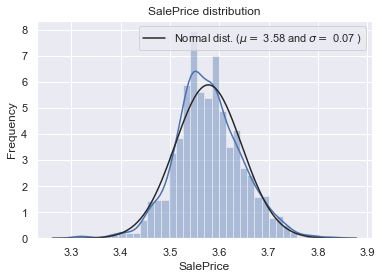

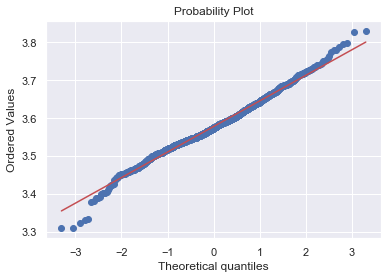

Skewness: 0.096942
Kurtosis: 0.838315


In [76]:
# Using Numpy log1p Function
y = np.log1p(y)

# Check the updated distribution
sns.distplot(y , fit=norm)

# Get the parameters of fit
(mu, sigma) = norm.fit(y)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(y, plot=plt)
plt.show()

y_train = train.SalePrice.values

print("Skewness: %f" % y.skew())
print("Kurtosis: %f" % y.kurt())

In [77]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE, r2_score

# Split Test and Training Data
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.3,  random_state=42)

# Steps for Linear Regression Pipeline, use Robust Scalar since we have some outliers
steps = [('scaler',RobustScaler()),
         ('LR',LinearRegression())]

LR_pipeline = Pipeline(steps)

LR_pipeline.fit(X_train,y_train)
LR_y_pred = LR_pipeline.predict(X_test)

# RMSE
LR_rmse_test = (MSE(y_test, LR_y_pred)) ** (1/2)

# R^2 Value 
LR_r2 = r2_score(y_test, LR_y_pred)

# Print the test set RMSE and R2
print('Linear Regression Test set RMSE: {:.2f}'.format(LR_rmse_test))
print('R2 Value: {:.4f}'.format(LR_r2))


Linear Regression Test set RMSE: 440342589.57
R2 Value: -40965492985633366016.0000


### Ridge Regression
Let us see if Ridge Regression will perform better than good old linear regression. Ridge regression adds an additional term to the OLS (Ordinary Least Squares) Error function. The parameter alhpa will need to be optimized for this model.

In [78]:
from sklearn.linear_model import Ridge 

ridge = Ridge(alpha=.005, normalize = False) 
ridge.fit(X_train, y_train)
ridge_y_pred = ridge.predict(X_test)
ridge.score(X_test, y_test)

# RMSE
ridge_rmse_test = (MSE(y_test, ridge_y_pred)) ** (1/2)

# R^2 Value 
ridge_r2 = r2_score(y_test, ridge_y_pred)

# Print the test set RMSE and R2
print('Linear Regression Test set RMSE: {:.4f}'.format(ridge_rmse_test))
print('R2 Value: {:.4f}'.format(ridge_r2))
print('MSE: {:.8f}'.format(MSE(y_test,ridge_y_pred)))

Linear Regression Test set RMSE: 0.0237
R2 Value: 0.8818
MSE: 0.00055964


In [79]:
from sklearn.linear_model import Ridge
# Steps for the Pipeline
steps = [('scaler', RobustScaler()),
         ('ridge', Ridge(normalize = False))]

# Instantiate Pipeline
pipeline = Pipeline(steps)

# Define Parameters of Ridge and search boundary
parameters = {'ridge__alpha':np.arange(7.5,8,0.01)}

# Perform GridSearchCV to optimize alpha
cv = GridSearchCV(pipeline, param_grid=parameters, scoring = 'neg_mean_squared_error')

# Fit model
cv.fit(X_train, y_train)
y_pred = cv.best_estimator_.predict(X_test)

# RMSE
rmse_test = (MSE(y_test, y_pred)) ** (1/2)

# R^2 Value 
r2 = r2_score(y_test, y_pred)

# Print the test set RMSE and R2
print('Ridge Regression Test set RMSE: {:.4f}'.format(rmse_test))
print('R2 Value: {:.4f}'.format(r2))
print('MSE: {:.5f}'.format(MSE(y_test, y_pred)))

Ridge Regression Test set RMSE: 0.0205
R2 Value: 0.9110
MSE: 0.00042


### Lasso Regression

Lasso regression does not square the term added to the OLS error function. Which means it will be less sensitive to outliers.

In [80]:
# Import Lasso
from sklearn.linear_model import Lasso

# Steps for Pipeline
steps = [('scaler', RobustScaler()),
         ('lasso', Lasso(normalize = False))]

# Instantiate Pipeline
pipeline = Pipeline(steps)

# Define Parameters of Lasso
parameters = {'lasso__alpha': np.arange(0,0.001,.0001)}

# Perform GridSearchCV to optimize alpha
cv = GridSearchCV(pipeline, param_grid=parameters, scoring = 'neg_mean_squared_error')

# Fit model
cv.fit(X_train, y_train)
y_pred = cv.best_estimator_.predict(X_test)

# RMSE
rmse_test = (MSE(y_test, y_pred)) ** (1/2)

# R^2 Value 
r2 = r2_score(y_test, y_pred)

# Print the test set RMSE and R2
print('Lasso Regression Test set RMSE: {:.4f}'.format(rmse_test))
print('R2 Value: {:.4f}'.format(r2))
print('MSE: {:.5f}'.format(MSE(y_test, y_pred)))

Lasso Regression Test set RMSE: 0.0205
R2 Value: 0.9110
MSE: 0.00042


### Elastic Net
Elastic net combines the l1 and l2 penalties of the lasso and ridge methods. 

In [81]:
# Import Elastic Net 
from sklearn.linear_model import ElasticNet

# Steps for Pipeline
steps = [('scaler', RobustScaler()),
         ('elasticnet', ElasticNet(normalize = False))]

# Instantiate Pipeline
pipeline = Pipeline(steps)

# Define Parameters of Lasso
parameters = {'elasticnet__alpha': np.arange(0,0.03,0.001),
              'elasticnet__l1_ratio': np.arange(0,.1,.01)}

# Perform GridSearchCV to optimize alpha
cv = GridSearchCV(pipeline, param_grid=parameters, scoring = 'neg_mean_squared_error')

# Fit model
cv.fit(X_train, y_train)

# Predict on Test Data
y_pred = cv.best_estimator_.predict(X_test)

# RMSE
rmse_test = (MSE(y_test, y_pred)) ** (1/2)

# R^2 Value 
r2 = r2_score(y_test, y_pred)

# Print the test set RMSE and R2
print('Lasso Regression Test set RMSE: {:.4f}'.format(rmse_test))
print('R2 Value: {:.4f}'.format(r2))
print('MSE: {:.5f}'.format(MSE(y_test, y_pred)))

Lasso Regression Test set RMSE: 0.0205
R2 Value: 0.9108
MSE: 0.00042


### Kernel Ridge Regression
KRR combines the ridge regression l2-norm regularization with the kernel trick. Kernel algorithms usually perform better in higher dimensional spaces.

In [116]:
# Import Kernel Ridge
from sklearn.kernel_ridge import KernelRidge

# Steps for Pipeline
steps = [('scaler', RobustScaler()),
         ('krr', KernelRidge(kernel='polynomial'))]

# Instantiate Pipeline
pipeline = Pipeline(steps)

# Define Parameters of Lasso
parameters = {'krr__alpha': np.arange(0.01,.2,.01),
              'krr__degree': [2]}

# Perform GridSearchCV to optimize alpha
cv = GridSearchCV(pipeline, param_grid=parameters, scoring = 'neg_mean_squared_error')

# Fit model
cv.fit(X_train, y_train)

# Predict on Test Data
y_pred = cv.best_estimator_.predict(X_test)

# RMSE
rmse_test = (MSE(y_test, y_pred)) ** (1/2)

# R^2 Value 
r2 = r2_score(y_test, y_pred)

# Print the test set RMSE and R2
print('KRR Regression Test set RMSE: {:.4f}'.format(rmse_test))
print('R2 Value: {:.4f}'.format(r2))
print('MSE: {:.8f}'.format(MSE(y_test, y_pred)))

KRR Regression Test set RMSE: 0.0202
R2 Value: 0.9139
MSE: 0.00040754


### Gradient Boosting Regressor

In [120]:
import xgboost as xgb
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

GBoost.fit(X_train, y_train)
y_pred = GBoost.predict(X_test) 

# RMSE
rmse_test = (MSE(y_test, y_pred)) ** (1/2)

# R^2 Value 
r2 = r2_score(y_test, y_pred)

# Print the test set RMSE and R2
print('KRR Regression Test set RMSE: {:.4f}'.format(rmse_test))
print('R2 Value: {:.4f}'.format(r2))
print('MSE: {:.8f}'.format(MSE(y_test, y_pred)))

KRR Regression Test set RMSE: 0.0214
R2 Value: 0.9029
MSE: 0.00045941
